In [1]:
import pyspark,pandas,datetime

In [2]:
from pyspark.storagelevel import StorageLevel

In [3]:
sc = pyspark.SparkContext()

### 数据请见./data/readme.md

In [6]:
rdd = sc.textFile("e:/110000.csv")\
.persist(StorageLevel.MEMORY_AND_DISK_SER)

In [7]:
rdd.take(5)

['2016-01-05 04:59:59,7d0971332e86c3e2920553e87044ac0a,116.580736,39.874868',
 '2016-01-05 05:00:00,a75008e5add9e088d5bd835b643f7d61,116.30374,40.044107',
 '2016-01-05 05:00:01,6403bc7585fb858d62b34299ed6fcfc4,116.398001,39.85221',
 '2016-01-05 05:00:00,47188e01448cedea702b100a504fe6ac,116.358788,39.854221',
 '2016-01-05 04:59:52,059475a2e6b75e35d5049b4e8f584396,116.011381,39.694151']

## 总记录数

In [8]:
rdd.count()

343862

In [18]:
res = rdd.map(lambda line : (line.split(",")[1],1))\
.reduceByKey(lambda x,y:(x+y))\
.sortBy(lambda x : (x[1],x),ascending=False)\
.collect()

In [19]:
pd = pandas.DataFrame(res)

In [20]:
print("总计有车辆数：",len(pd))

总计有车辆数： 8028


## 排名前20的数据

In [21]:
pd.head(20)

,0,1
0,89cac57f1d6028aeb9d702fa353bff86,3963
1,e8fe4791e9a043dcf3fb567d5969a327,3790
2,6877c4b90ec348a5cbb226ce0790aa5c,1095
3,e03b8ea935007d83886601be21603633,794
4,35e6a4c4f5b4f9379d16a7133d24cae1,726
5,6d3724ea10543db709eaab5c820170b0,721
6,75fe982f37b768e348eadcec92d080c4,702
7,7143510ffdbd5bef813a244e1981c5e4,701
8,4a3c796403a2bb1b921ba79b4331e7f2,701
9,bdd7ab02a9bbc5ffb9b2735185798ecc,700


In [22]:
def mymap(line):
    xy = line.split(",")
    x = float(xy[2])
    y = float(xy[3])
    return ("extent",[x,x,y,y])

In [23]:
res = rdd.map(lambda line:mymap(line))\
.reduceByKey(lambda x,y : (max(x[0],y[0]),
                           min(x[1],y[1]),
                           max(x[2],y[2]),
                           min(x[3],y[3]))).collect()

## 空间范围

In [24]:
res

[('extent', (117.499035, 115.20195, 41.09803, 39.400021))]

## 时间范围

In [25]:
rdd.sortBy(lambda line : (datetime.datetime.strptime(line.split(",")[0], 
                                                      '%Y-%m-%d %H:%M:%S'),line),
           ascending=True).take(1)

['2016-01-05 00:00:02,212129de5f2e3cdb98c45361c5aebcb7,116.426608,39.949036']

In [26]:
rdd.sortBy(lambda line : (datetime.datetime.strptime(line.split(",")[0], 
                                                      '%Y-%m-%d %H:%M:%S'),line),
           ascending=False).take(1)

['2016-01-05 10:11:32,384cf23faf81ec9d3a84006338546124,116.502436,39.988393']

# 数据分布密度

In [27]:
import pygeohash
import matplotlib.pyplot as plt
import numpy

In [28]:
def geohashMap(line):
    xy = line.split(",")
    return (pygeohash.encode(float(xy[3]),
                             float(xy[2]),5),1)

In [29]:
res = rdd.map(lambda line : geohashMap(line))\
.reduceByKey(lambda x,y : x+y)\
.collect()

In [30]:
x = []
y = []
z = []
for r in res:
    xy = pygeohash.decode(r[0])
    x.append(float(xy[1]))
    y.append(float(xy[0]))
    z.append(r[1])

## 利用ArcGIS进行核密度分析

In [31]:
import arcpy

In [38]:
if arcpy.Exists("in_memory/tempPnt"):
    arcpy.Delete_management("in_memory/tempPnt")
feature_class = arcpy.CreateFeatureclass_management("in_memory",
                                                    "tempPnt", "POINT")[0]
arcpy.AddField_management("in_memory/tempPnt","v","SHORT")

<Result 'in_memory/tempPnt'>

In [39]:
with arcpy.da.InsertCursor(feature_class, ["SHAPE@XY","v"]) as cursor:
    for r in res:
        xy = pygeohash.decode(r[0])
        cursor.insertRow([(float(xy[1]), float(xy[0])),r[1]])

In [40]:
arcpy.CheckOutExtension("Spatial")
populationField = "v"
cellSize = 0.001
searchRadius = 0.1
unit = "SQUARE_KILOMETERS"

In [41]:
outKernelDensity = arcpy.sa.KernelDensity(feature_class, populationField, cellSize,
                                 searchRadius, unit)

In [42]:
import json
with arcpy.da.SearchCursor("./data/bj.shp", ["SHAPE@JSON"]) as cursor:
    for r in cursor:
        bj = json.loads(r[0])["rings"][0]

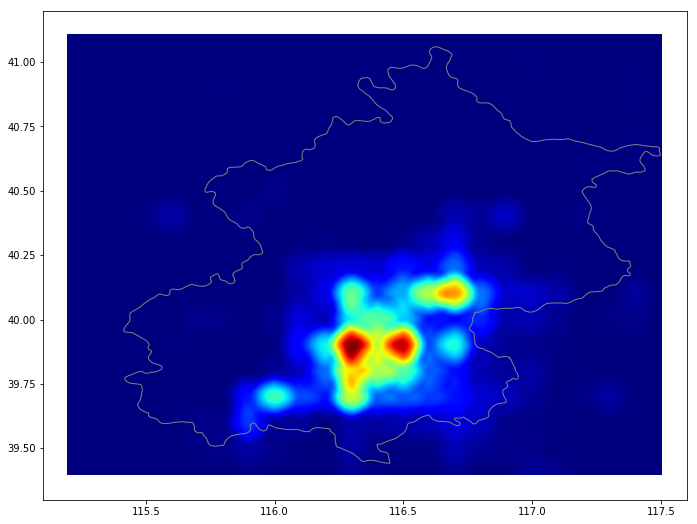

In [48]:
desc = arcpy.Describe(outKernelDensity).extent
fig = plt.figure(figsize=(14,9))
plt.imshow(arcpy.RasterToNumPyArray(outKernelDensity),
           extent=[desc.XMin,desc.XMax,desc.YMin,desc.YMax],
           cmap =plt.cm.jet)
ax = fig.gca()
ax.add_patch(plt.Polygon(bj,ec="gray",fc="None"))
ax.set_xlim(115.1,117.6)
ax.set_ylim(39.3,41.2)
plt.show()